In [1]:
%load_ext autoreload
%autoreload 1
%aimport dlqmc.NN, dlqmc.Sampler, dlqmc.Examples
%aimport dlqmc.utils, dlqmc.sampling, dlqmc.analysis, dlqmc.gto, dlqmc.physics, dlqmc.nn
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 300}

In [354]:
from collections import namedtuple

import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler
from torch.distributions import Normal
import pyscf
from pyscf import gto, scf, dft
from pyscf.data.nist import BOHR
from tqdm import tqdm_notebook, tnrange

from dlqmc.Sampler import HMC
from dlqmc.nn import WFNet
import dlqmc.nn
from dlqmc.sampling import langevin_monte_carlo
from dlqmc.utils import (
    plot_func, get_flat_mesh, assign_where, plot_func_xy,
    plot_func_x, integrate_on_mesh
)
from dlqmc.physics import (
    local_energy, grad, quantum_force, nuclear_cusps, Geometry,
    nuclear_energy
)
from dlqmc.gto import GTOWF
from dlqmc.analysis import autocorr_coeff, blocking

In [207]:
h_atom = Geometry([[1., 0., 0.]], [1.])
he_plus = Geometry([[1., 0., 0.]], [2.])
h2_plus = Geometry([[-1., 0., 0.], [1., 0., 0.]], [1., 1.])
he2_3plus = Geometry([[-1., 0., 0.], [1., 0., 0.]], [2., 2.])

## Net WF

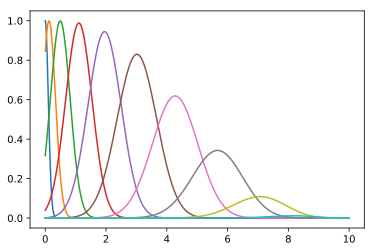

In [373]:
def cutoff(x, cutoff):
    x_rel = x/cutoff
    return 1-6*x_rel**5+15*x_rel**4-10*x_rel**3
    
for q in np.linspace(0, 1, 10):
    plot_func(
        lambda x: cutoff(x, 10)*np.exp(-(7/(1+10*q))**2*(x-10*q**2)**2),
        [0, 10]
    )

In [375]:
tau = 0.1
n_walker = 1_000
n_steps = 500
samples, info = langevin_monte_carlo(
    net,
    torch.randn(n_walker, 3),
    n_steps,
    tau,
    range=tnrange
)
info

{'acceptance': 0.984798}

In [376]:
rs_dl = iter(DataLoader(samples.view(-1, 3), batch_size=10_000, shuffle=True))

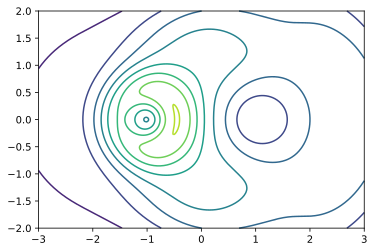

In [380]:
plot_func_xy(
    lambda x: wf._nn(wf._featurize(x)[1]).squeeze(),
    [[-3, 3], [-2, 2]]
);

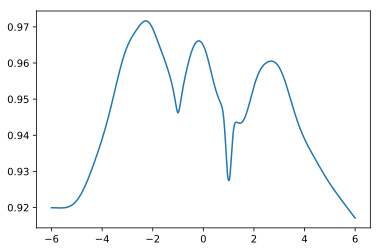

In [669]:
plot_func_x(
    lambda x: torch.exp(wfnet._nn(net._featurize(x)[1])).squeeze(),
    [-6, 6]
)

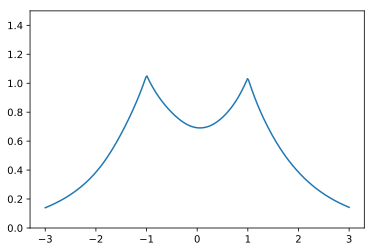

In [383]:
plot_func_x(wf, [-3, 3]);
plt.ylim(0, 1.5);

In [660]:
def fit(wf, geom, E_ref, n_steps=100, range=range, lr=0.005):
    opt = torch.optim.Adam(wf.parameters(), lr=lr)
    for i in range(n_steps):
        rs = 3*torch.randn(10_000, 3)
        Es_loc, psis = local_energy(rs, wf, geom, create_graph=True)
        ws = psis**2/psis.detach()**2
        loss = (ws*(Es_loc-E_ref)**2).mean()/ws.mean()
        print(*(x.item() for x in (
            loss, Es_loc.mean(), Es_loc.var(), wf._ion_pot
        )))
        loss.backward()
        opt.step()
        opt.zero_grad()

In [378]:
wf = WFNet(h2_plus, ion_pot=0.5)

In [667]:
fit(wf, h2_plus, -0.6, n_steps=100)

0.38943973183631897 -0.017992861568927765 0.05071239918470383 0.5
0.38886505365371704 -0.016617964953184128 0.04853525385260582 0.5049999952316284
0.38318270444869995 -0.019040457904338837 0.04567325487732887 0.509998083114624
0.3763526976108551 -0.02570836804807186 0.04654638469219208 0.5149980783462524
0.36653727293014526 -0.03414294868707657 0.04634770005941391 0.5199997425079346
0.3601401150226593 -0.035787757486104965 0.04180881753563881 0.5249997973442078
0.3498430848121643 -0.05038550868630409 0.04777175560593605 0.5300062894821167
0.33847832679748535 -0.06176776811480522 0.04878918454051018 0.5350125432014465
0.31886258721351624 -0.07439564913511276 0.04260688275098801 0.5400210618972778
0.3029807507991791 -0.09476829320192337 0.04772637039422989 0.5450350046157837
0.28345632553100586 -0.12110324949026108 0.05411957576870918 0.5500530004501343
0.2607899308204651 -0.15374374389648438 0.06165141239762306 0.5550711750984192
0.24097628891468048 -0.19438046216964722 0.07645667344331

In [636]:
rs = 3*torch.randn(10_000, 3)
# rs = next(rs_dl)
E_loc, psi = local_energy(rs, net, h2_plus, create_graph=True)
# E_loc.mean(), E_loc.var()

In [638]:
psi

tensor([0.0343, 0.0523, 0.1368,  ..., 0.1413, 0.0368, 0.0888],
       grad_fn=<MulBackward0>)

In [633]:
loss = ((E_loc+0.602)**2).sum()
loss

tensor(3920.1992, grad_fn=<SumBackward0>)

In [634]:
loss.backward()
opt.step()
opt.zero_grad()

In [635]:
E_loc = local_energy(rs, net, h2_plus)
E_loc.mean(), E_loc.var(), ((E_loc+0.602)**2).sum()

(tensor(-0.0225), tensor(0.0508), tensor(3866.3547))

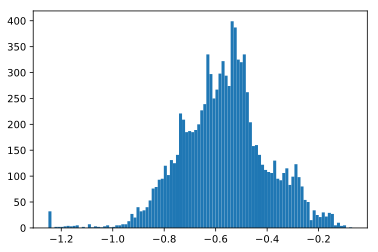

In [477]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

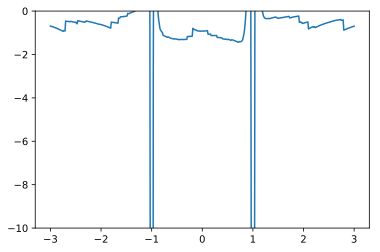

In [29]:
plt.plot(
    x_line[:, 0].numpy(),
    local_energy(lambda x: net(x, coords), x_line, coords, charges).detach().numpy()
)
plt.ylim((-10, 0));

In [30]:
samples = HMC_ad(
    dist=lambda x: net(x, coords).squeeze()**2,
    stepsize=0.1,
    dysteps=3,
    n_walker=100,
    steps=5000,
    dim=3,
    push=1,
    startfactor=1,
    presteps=50,
).detach().reshape(-1, 3)

Acceptanceratio: 87.12%


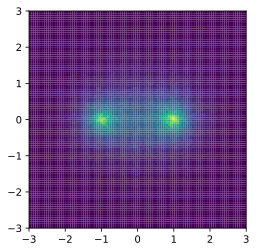

In [31]:
plt.hist2d(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [32]:
E_loc = local_energy(lambda x: net(x, coords), samples, coords, charges)

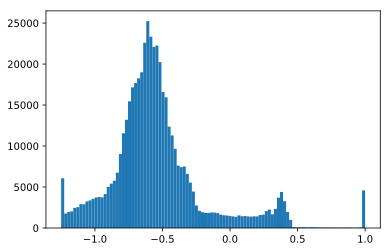

In [33]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [35]:
E_loc.mean().item()

-0.5168347954750061

## GTO WF

In [333]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf2 = scf.RHF(mol)
scf_energy = mf2.kernel()
gtowf2 = GTOWF(mf2, 0)

converged SCF energy = -0.602622271479771


In [ ]:
gtowf2

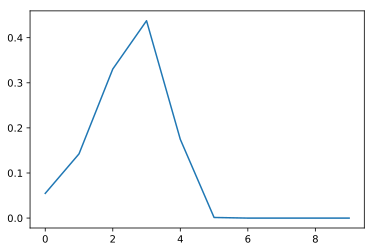

In [347]:
plt.plot(gtowf._mo_coeffs[:10])

In [372]:
(gtowf2._mo_coeffs > 1e-3).nonzero()

(array([  0,   1,   2,   3,   4,   6,   9,  12,  15,  18,  30,  35,  40,
         80,  81,  82,  83,  84, 110, 115, 120]),)

In [370]:
mol = gto.M(
    atom=[
        [1, (-1, 0, 0)],
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=0,
    spin=1,
)
mf = scf.RHF(mol)
scf_energy = mf.kernel()
gtowf = GTOWF(mf, 0)

converged SCF energy = -0.499994784583708


In [364]:
(gtowf._mo_coeffs > 1e-4).nonzero()

(array([0, 1, 2, 3, 4, 5]),)

In [ ]:

plot_func_x(lambda x: pyscf.dft.numint.eval_ao(gtowf._mol, x.numpy()), [-20, 20]);

/srv/hdd/jhermann/.cache/conda/envs/dl-qmc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


(-20, 0)

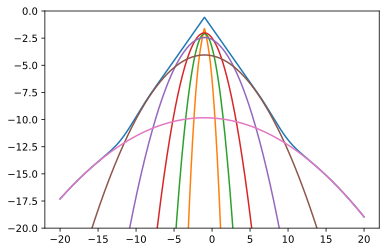

In [376]:
# plot_func_x(lambda x: torch.log(gtowf2(x)), [-20, 20]);
plot_func_x(lambda x: torch.log(gtowf(x)), [-20, 20]);
for i in range(6):
    plot_func_x(lambda x: np.log(gtowf._mo_coeffs[i] * pyscf.dft.numint.eval_ao(gtowf._mol, x)[:, i]), [-20, 20], is_torch=False);
plt.ylim(-20, 0)

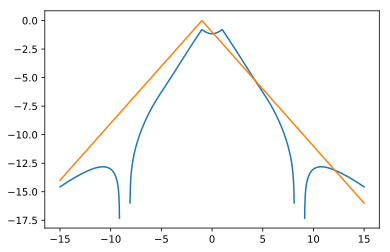

In [377]:
wfnet = WFNet(h2_plus, ion_pot=0.5, alpha=100.)
plot_func_x(lambda x: torch.log(gtowf2(x)), [-15, 15]);
plot_func_x(
    lambda x: torch.log(wfnet._asymptote(wfnet._featurize(x)[0])),
    [-15, 15]
);

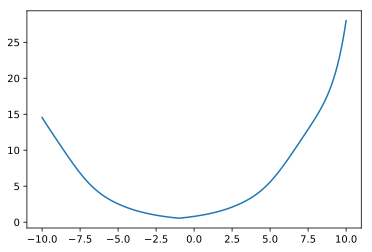

In [253]:
wfnet = WFNet(h2_plus, ion_pot=0.96, alpha=10)
plot_func_x(
    lambda x: gtowf(x)/wfnet._asymptote(wfnet._featurize(x)[0]),
    [-10, 10]
);

In [42]:
1/2.6

0.3846153846153846

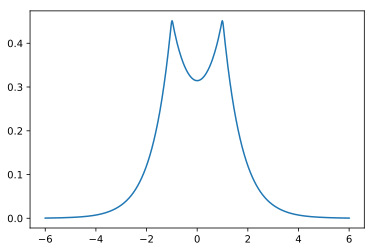

In [37]:
plot_func_x(
    gtowf,
    [-6, 6,]
);

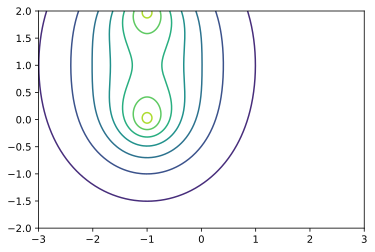

In [150]:
plot_func_xy(gtowf2, [[-3, 3], [-2, 2]]);

In [33]:
integrate_on_mesh(lambda x: gtowf(x)**2, [(-6, 6), (-4, 4), (-4, 4)])

tensor(0.9931)

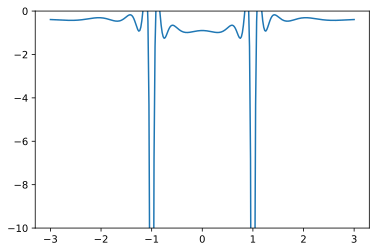

In [10]:
plot_func_x(lambda x: local_energy(x, gtowf, h2_plus), [-3, 3])
plt.ylim((-10, 0));

In [367]:
samples = HMC(
    dist=lambda x: wf_from_mf(x, mf, 0)**2,
    stepsize=np.sqrt(0.1),
    dysteps=0,
    n_walker=100,
    steps=5000,
    dim=3,
    startfactor=1,
    presteps=100,
).detach().transpose(0, 1).contiguous()

100%|██████████| 5100/5100 [00:26<00:00, 195.31it/s]


Acceptanceratio: 80.29%


In [61]:
tau = 0.1
n_walker = 1_000
n_steps = 500
samples, info = langevin_monte_carlo(
    gtowf,
    torch.randn(n_walker, 3),
    n_steps,
    tau,
    range=tnrange
)
info

{'acceptance': 0.978734}

In [68]:
E_loc = local_energy(samples.view(-1, 3), gtowf, h2_plus).view(100, -1)

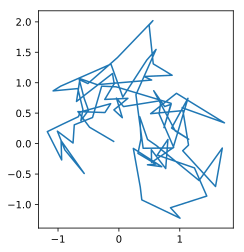

In [69]:
plt.plot(*samples[0][:100, :2].numpy().T)
plt.gca().set_aspect(1)

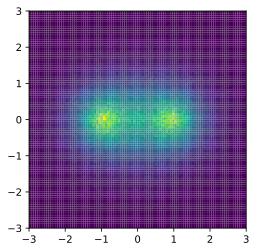

In [76]:
plt.hist2d(
    *samples.view(-1, 3)[:, :2].numpy().T,
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

(-0.7, -0.5)

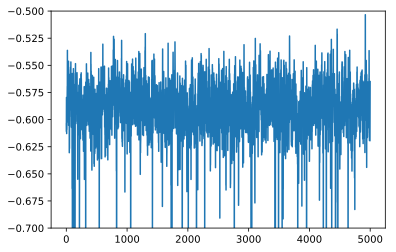

In [75]:
plt.plot(E_loc.mean(0).numpy())
plt.ylim(-0.7, -0.5)

In [77]:
E_loc.std()

tensor(0.3293)

In [78]:
(E_loc.mean(dim=-1).std()*np.sqrt(5000)/E_loc.std())**2

tensor(3.3421)

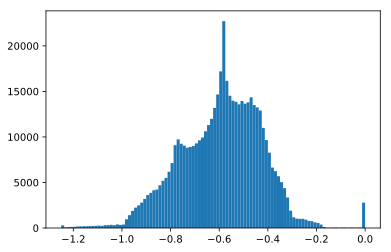

In [80]:
plt.hist(E_loc.flatten().clamp(-1.25, 0).numpy(), bins=100);

In [48]:
scf_energy, E_loc.mean().item(), (E_loc.mean(dim=-1).std()/np.sqrt(100)).item()

(-0.5904789926457443, -0.5905352830886841, 0.0009674459579400718)

In [57]:
results = ([], [])
with open('/storage/mi/jhermann/Research/Projects/nqmc/_dev/test-calc-2/h2+-hf-vmc.qw.log') as f:
    for l in f:
        words = l.split()
        if words and words[0].startswith('total_energy'):
            i = 1 if words[0].endswith('var') else 0
            results[i].append(words[2])
results = torch.tensor(np.array(results, dtype=float).T)

In [58]:
avg = results[:, 0].mean()
avg

tensor(-0.5902, dtype=torch.float64)

In [136]:
avgvar = (results[:, 1].view(-1, 1).norm(dim=-1)).mean().item()
np.sqrt(avgvar)

0.3250514804846397

In [137]:
(results[:, 0].var() + results[:, 1].mean()).sqrt().item()

0.325348706875114

In [139]:
err = (results[:, 0].std(unbiased=False).item()/np.sqrt(500))**2
np.sqrt(err)

0.0006211754467984398

In [140]:
indep_points = avgvar/err
indep_points

273826.6635503522

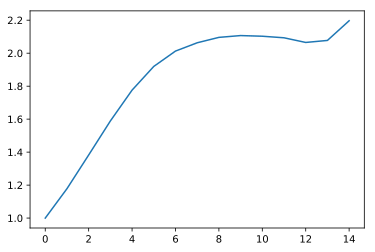

In [68]:
plt.plot(*np.array(list(map(blocking, E_loc))).mean(0).T)

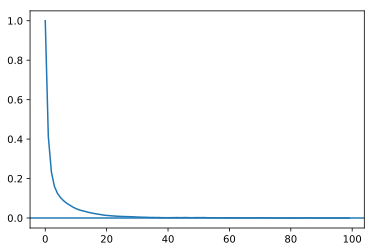

In [69]:
plt.plot(np.array(list(map(lambda x: autocorr_coeff(range(100), x), E_loc))).mean(0))
plt.axhline()